### Preprocessing Data: Pairing Arcs

In [ ]:
import pandas as pd

# === Load datasets ===
demand_df = pd.read_csv("customer_demand.csv")
shipments_df = pd.read_csv("cleaned_shipments.csv")

# === Step 1: Preprocess Dates ===
demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")

# === Step 2: Infer Journey Type from Destination ID (Import / Export / Unknown) ===
def infer_journey_type(row):
    dest = row["destination_location_id"]
    if isinstance(dest, str) and dest.startswith("TR_CU"):
        return "import"
    elif isinstance(dest, str) and dest.startswith("TR_OP"):
        return "export"
    else:
        return "unknown"

demand_df["journey_type"] = demand_df.apply(infer_journey_type, axis=1)

# === Step 3: Mark Transit Trips from Shipments File ===
# We'll mark a trip as "transit" if its movement_type_desc contains 'Transit'
def mark_transit(row):
    return row["Traffic Direction"] == "Transit"

shipments_df["is_transit"] = shipments_df.apply(mark_transit, axis=1)

# === Step 4: Build the set of Transit Trips ===
# (using source-destination-container-type key matching)
transit_keys = set(
    zip(
        shipments_df.loc[shipments_df["is_transit"], "source_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "destination_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "container_type"]
    )
)

print(f"🔵 Total Transit Arcs Identified: {len(transit_keys)}")

🔵 Total Transit Arcs Identified: 32


In [ ]:
# === Step 5: Aggregate Demand Volumes by Location, Date, Journey Type ===
journey_summary = (
    demand_df.groupby(["destination_location_id", "date_str", "journey_type"])["q_i"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# === Step 6: Identify Paired Opportunities ===
journey_summary["paired"] = (journey_summary.get("import", 0) > 0) & (journey_summary.get("export", 0) > 0)

# === Step 7: Report Summary Stats ===
total_cases = len(journey_summary)
paired_cases = journey_summary["paired"].sum()
percent_paired = 100 * paired_cases / total_cases if total_cases > 0 else 0

print(f"\n📈 Total location-date combinations: {total_cases}")
print(f"🔗 Paired import/export opportunities: {paired_cases}")
print(f"✅ Pairing ratio: {percent_paired:.2f}%")

# === Step 8: Save or Export Journey Summary if needed ===
journey_summary.to_csv("import_export_pairing_summary.csv", index=False)


📈 Total location-date combinations: 3911
🔗 Paired import/export opportunities: 0
✅ Pairing ratio: 0.00%


In [ ]:
# === Step 9: Define Valid Keys for Optimization ===
# (Include Transit Trips without changing them later)

# Load arcs
arcs_df = pd.read_csv("cleaned_arcs.csv")
arcs = list(zip(arcs_df['source_location_id'], arcs_df['destination_location_id']))

# Build valid keys for optimization
valid_keys = set()
for _, row in demand_df.iterrows():
    dest = row["destination_location_id"]
    cont = row["container_type"]
    date = row["date_str"]

    # For each destination, match source-destination arcs (arcs must end at destination)
    for (src, dst) in arcs:
        if dst == dest:
            valid_keys.add((src, dst, cont, date))

print(f"📦 Total Valid Keys (source-destination-container-date combinations): {len(valid_keys)}")

📦 Total Valid Keys (source-destination-container-date combinations): 578756


In [ ]:
# Build an indexed dictionary for fast lookup
from collections import defaultdict

valid_keys_by_jkd = defaultdict(list)

for (i, j, k, d) in valid_keys:
    valid_keys_by_jkd[(j, k, d)].append((i, j, k, d))

## Optimization Code

In [ ]:
!pip install gurobipy

import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# === Load Data ===
arcs_df = pd.read_csv("cleaned_arcs.csv")
demand_df = pd.read_csv("customer_demand.csv")
shipments_df = pd.read_csv("cleaned_shipments.csv")

# === Preprocess Dates ===
demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
dates = sorted(demand_df["date_str"].unique())
container_types = demand_df["container_type"].unique()

# === Mark Transit Trips Correctly ===
shipments_df["is_transit"] = shipments_df["Traffic Direction"] == "Transit"

# === Build Demand Dictionary ===
demand = {}
for _, row in demand_df.iterrows():
    key = (row["destination_location_id"], row["container_type"], row["date_str"])
    demand[key] = demand.get(key, 0) + row["q_i"]

# === Sets & Parameters ===
fixed_cost_per_km = 1.0
spot_multiplier = 1.15
max_fixed_trucks = 18  # <<< updated to 18 trucks
max_daily_distance = 400  # 8 hrs x 50 mph

nodes = set(arcs_df['source_location_id']).union(set(arcs_df['destination_location_id']))
arcs = list(zip(arcs_df['source_location_id'], arcs_df['destination_location_id']))
distance = {(row['source_location_id'], row['destination_location_id']): row['avg_distance']
            for _, row in arcs_df.iterrows()}

# Build Transit Key Set
transit_keys = set(
    zip(
        shipments_df.loc[shipments_df["is_transit"], "source_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "destination_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "container_type"]
    )
)

# === Build Valid Keys ===
valid_keys = set()
for (j, k, d) in demand:
    for (i, j2) in arcs:
        if j == j2:
            valid_keys.add((i, j, k, d))

print(f"Model has {len(valid_keys)} shipment variables per fleet (xf and xs)")
print(f"Transit Keys Identified: {len(transit_keys)}")

# === Setup Gurobi Environment ===
params = {
    "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
    "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
    "LICENSEID": 2615231
}
env = gp.Env(params=params)

# === Optimization Model ===
model = gp.Model(env=env)

# Force set critical parameters again at the model level
model.setParam("TimeLimit", 300)

# === Decision Variables ===
xf = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xf")  # Fixed fleet
xs = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xs")  # Spot fleet
total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

# === Demand Constraints ===
for (j, k, d) in demand:
    incoming = valid_keys_by_jkd.get((j, k, d), [])
    total = gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming)
    model.addConstr(total >= demand[(j, k, d)], name=f"demand_{j}_{k}_{d}")

# === Transit Trip Preservation Constraints ===
for (src, dst, cont) in transit_keys:
    for d in dates:
        if (src, dst, cont, d) in valid_keys:
            # Transit trips must exactly match their original move: fixed only
            model.addConstr(
                xf[src, dst, cont, d] >= 1,
                name=f"transit_trip_{src}_{dst}_{cont}_{d}"
            )

# === Daily Fixed Truck Limits (fleet size cap) ===
for d in dates:
    daily_fixed_total = gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
    model.addConstr(daily_fixed_total <= max_fixed_trucks, name=f"fixed_limit_{d}")

# === Driving Distance Constraint (8 hrs per day cap) ===
for d in dates:
    daily_driving_distance = gp.quicksum(
        distance[i, j] * (xf[i, j, k, d1] + xs[i, j, k, d1])
        for (i, j, k, d1) in valid_keys if d1 == d
    )
    model.addConstr(
        daily_driving_distance <= max_daily_distance * (max_fixed_trucks + total_spot),
        name=f"daily_driving_limit_{d}"
    )

# === Spot Tracker ===
model.addConstr(
    total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys),
    name="spot_total"
)

# === Objective Function ===
model.setObjective(
    gp.quicksum(
        (fixed_cost_per_km) * distance[i, j] * xf[i, j, k, d] +
        (fixed_cost_per_km * spot_multiplier) * distance[i, j] * xs[i, j, k, d]
        for (i, j, k, d) in valid_keys
    ) + 50 * total_spot,
    GRB.MINIMIZE
)

model.setParam("PoolSearchMode", 2)        # Search aggressively for multiple solutions
model.setParam("PoolGap", 0.05)             # Allow solutions up to 5% worse than best objective
model.setParam("PoolSolutions", 10)         # Save up to 10 alternate solutions

# === Solve Model ===
model.optimize()

# === Report Results ===
if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
    print(f"\n✅ Full Optimization Complete:")
    print(f"Objective: {model.ObjVal:.2f}")
    print(f"Spot Trucks Used: {total_spot.X:.0f}")
    print(f"Fixed Trucks Used: {sum(xf[i, j, k, d].X for (i, j, k, d) in valid_keys)}")
else:
    print(f"❌ Optimization failed or infeasible (status: {model.status})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 63.8 MB/s eta 0:00:00
Model has 578756 shipment variables per fleet (xf and xs)
Transit Keys Identified: 32
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter TimeLimit to value 300
Set parameter PoolSearchMode to value 2
Set parameter PoolGap to value 0.05
Set parameter PoolSolutions to value 10
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300
PoolSearchMode  2
PoolGap  0.05

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 7042 rows, 1157513 columns and 3473896 nonzeros
Model fingerprint: 0x9ac798e0


## Alternate Solutions

In [ ]:
nSolutions = model.SolCount
print(f"Total solutions found: {nSolutions}")

for sol in range(nSolutions):
    model.Params.SolutionNumber = sol
    objVal = model.PoolObjVal
    print(f"Solution {sol}: Objective = {objVal}")

Total solutions found: 10
Solution 0: Objective = 2257717.513235202
Solution 1: Objective = 2257755.9279352026
Solution 2: Objective = 2257813.427935202
Solution 3: Objective = 2257820.9279352026
Solution 4: Objective = 2257828.6779352026
Solution 5: Objective = 2257832.1279352023
Solution 6: Objective = 2257834.7279352024
Solution 7: Objective = 2257840.6779352026
Solution 8: Objective = 2257900.5030663
Solution 9: Objective = 2257938.6779352026


In [ ]:
# Example: Analyze all xf variables (fixed trucks) for each solution
for sol in range(nSolutions):
    model.Params.SolutionNumber = sol
    print(f"\n--- Solution {sol} ---")
    fixed_truck_assignments = {key: xf[key].Xn for key in valid_keys if xf[key].Xn > 0}
    spot_truck_assignments = {key: xs[key].Xn for key in valid_keys if xs[key].Xn > 0}
    print(f"Fixed Truck Moves: {len(fixed_truck_assignments)}")
    print(f"Spot Truck Moves: {len(spot_truck_assignments)}")


--- Solution 0 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3375

--- Solution 1 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 2 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 3 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 4 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 5 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 6 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 7 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376

--- Solution 8 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3377

--- Solution 9 ---
Fixed Truck Moves: 2891
Spot Truck Moves: 3376


## Binding Constraints

In [ ]:
for v in model.getVars():
    v.vtype = GRB.CONTINUOUS  # Force all variables to be continuous (relax integers)

model.update()
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300
PoolSearchMode  2
PoolGap  0.05

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 7042 rows, 1157513 columns and 3473896 nonzeros
Model fingerprint: 0xcb4b52a9
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve time: 8.65s
Presolved: 5772 rows, 1157513 columns, 3343185 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1869436e+05   6.946367e+04   0.000000e+00      9s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0       

In [ ]:
binding_constraints = []

for constr in model.getConstrs():
    slack = constr.Slack
    pi = constr.Pi
    cname = constr.ConstrName

    if abs(slack) < 1e-6:  # Binding constraint
        binding_constraints.append((cname, pi))

print(f"Total binding constraints: {len(binding_constraints)}")

# Sort by shadow price
binding_constraints = sorted(binding_constraints, key=lambda x: abs(x[1]), reverse=True)

for cname, pi in binding_constraints[:20]:  # Top 20
    print(f"{cname}: Shadow Price = {pi:.2f}")

Total binding constraints: 6595
demand_TR_CU_00009904_20DRY86_2024-03-13: Shadow Price = 2384.34
demand_TR_CU_00009904_20DRY86_2024-02-02: Shadow Price = 2238.72
demand_TR_CU_00009904_20DRY86_2024-04-20: Shadow Price = 2238.72
demand_TR_CU_00006373_40REEF96_2024-06-06: Shadow Price = 2073.98
demand_TR_OP_00000025_20DRY86_2024-04-26: Shadow Price = 1893.97
demand_TR_CU_00010978_40DRY96_2024-04-18: Shadow Price = 1850.35
demand_TR_CU_00010046_40DRY96_2024-08-28: Shadow Price = 1651.53
demand_TR_CU_00010046_20DRY86_2024-07-05: Shadow Price = 1647.14
demand_TR_CU_00010046_40DRY96_2024-10-15: Shadow Price = 1647.08
demand_TR_CU_00010046_20DRY86_2024-11-12: Shadow Price = 1646.92
demand_TR_CU_00010046_20DRY86_2024-08-12: Shadow Price = 1646.06
demand_TR_CU_00010046_20DRY86_2024-12-10: Shadow Price = 1645.55
demand_TR_CU_00010046_40DRY96_2024-11-13: Shadow Price = 1645.24
demand_TR_CU_00010046_20DRY86_2024-10-30: Shadow Price = 1643.45
demand_TR_CU_00010046_20DRY86_2024-11-26: Shadow Price = 

In [ ]:
corridor_summary_list = []

for cname, pi in binding_constraints:
    if cname.startswith("demand_"):
        try:
            parts = cname.split("_")
            dest = f"{parts[1]}_{parts[2]}_{parts[3]}"  # Proper destination ID
            cont = parts[4]  # Container type
            date = parts[5]  # Correct date (already formatted as YYYY-MM-DD)

            matching_shipment = shipments_df[
                (shipments_df["destination_location_id"] == dest) &
                (shipments_df["container_type"] == cont)
            ]

            if not matching_shipment.empty:
                src = matching_shipment.iloc[0]["source_location_id"]
                corridor = f"{src} ➔ {dest}"
            else:
                corridor = f"Unknown ➔ {dest}"

            corridor_summary_list.append({
                "Corridor": corridor,
                "Container_Type": cont,
                "Date": date,
                "Shadow_Price": pi
            })
        except Exception as e:
            print(f"Skipping constraint {cname} due to parsing error: {e}")

# Build the DataFrame
corridor_summary_df = pd.DataFrame(corridor_summary_list)

# Sort it nicely
corridor_summary_df = corridor_summary_df.sort_values(by="Shadow_Price", ascending=False)

# Display
print(corridor_summary_df.head(10))

                          Corridor Container_Type        Date  Shadow_Price
0  TR_OP_00000033 ➔ TR_CU_00009904        20DRY86  2024-03-13   2384.344464
2  TR_OP_00000033 ➔ TR_CU_00009904        20DRY86  2024-04-20   2238.719333
1  TR_OP_00000033 ➔ TR_CU_00009904        20DRY86  2024-02-02   2238.719333
3  TR_OP_00000071 ➔ TR_CU_00006373       40REEF96  2024-06-06   2073.975644
4  TR_CU_00005324 ➔ TR_OP_00000025        20DRY86  2024-04-26   1893.967765
5  TR_OP_00000063 ➔ TR_CU_00010978        40DRY96  2024-04-18   1850.353118
6  TR_OP_00000031 ➔ TR_CU_00010046        40DRY96  2024-08-28   1651.530644
7  TR_OP_00000031 ➔ TR_CU_00010046        20DRY86  2024-07-05   1647.143030
8  TR_OP_00000031 ➔ TR_CU_00010046        40DRY96  2024-10-15   1647.075681
9  TR_OP_00000031 ➔ TR_CU_00010046        20DRY86  2024-11-12   1646.915985


## Simulation Distributions - Demand

In [ ]:
import numpy as np

def bootstrap_demand(demand_df, seed=None):
    """
    Bootstraps the demand_df by resampling rows with replacement.
    """
    if seed is not None:
        np.random.seed(seed)
    boot_df = demand_df.sample(n=len(demand_df), replace=True, random_state=seed).reset_index(drop=True)
    return boot_df

In [ ]:
bootstrap_results = []

for run in range(10):
    print(f"\n🔁 Running Demand Bootstrap Simulation {run+1}...")

    # Step 1: Bootstrap demand
    sim_demand_df = bootstrap_demand(demand_df, seed=100 + run)
    sim_demand_df["Customer Promised Date"] = pd.to_datetime(sim_demand_df["Customer Promised Date"])
    sim_demand_df["date_str"] = sim_demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
    dates = sorted(sim_demand_df["date_str"].unique())

    # Step 2: Rebuild demand dictionary
    demand = {}
    for _, row in sim_demand_df.iterrows():
        key = (row["destination_location_id"], row["container_type"], row["date_str"])
        demand[key] = demand.get(key, 0) + row["q_i"]

    # Step 3: Rebuild valid keys
    valid_keys = set()
    for (j, k, d) in demand:
        for (i, j2) in arcs:
            if j == j2:
                valid_keys.add((i, j, k, d))

    valid_keys_by_jkd = defaultdict(list)
    for (i, j, k, d) in valid_keys:
        valid_keys_by_jkd[(j, k, d)].append((i, j, k, d))

    # Step 4: Set up and solve MILP
    env = gp.Env(params=params)
    model = gp.Model(env=env)
    model.setParam("TimeLimit", 300)

    xf = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xf")
    xs = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xs")
    total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

    for (j, k, d) in demand:
        incoming = valid_keys_by_jkd.get((j, k, d), [])
        total = gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming)
        model.addConstr(total >= demand[(j, k, d)], name=f"demand_{j}_{k}_{d}")

    for d in dates:
        daily_fixed_total = gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
        model.addConstr(daily_fixed_total <= max_fixed_trucks, name=f"fixed_limit_{d}")

    for d in dates:
        daily_driving_distance = gp.quicksum(
            distance[i, j] * (xf[i, j, k, d1] + xs[i, j, k, d1])
            for (i, j, k, d1) in valid_keys if d1 == d
        )
        model.addConstr(
            daily_driving_distance <= max_daily_distance * (max_fixed_trucks + total_spot),
            name=f"daily_driving_limit_{d}"
        )

    model.addConstr(
        total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys),
        name="spot_total"
    )

    model.setObjective(
        gp.quicksum(
            (fixed_cost_per_km) * distance[i, j] * xf[i, j, k, d] +
            (fixed_cost_per_km * spot_multiplier) * distance[i, j] * xs[i, j, k, d]
            for (i, j, k, d) in valid_keys
        ) + 50 * total_spot,
        GRB.MINIMIZE
    )

    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        obj = model.ObjVal
        spot = total_spot.X
        fixed = sum(xf[i, j, k, d].X for (i, j, k, d) in valid_keys)
        print(f"✅ Run {run+1} Complete — Objective: {obj:.2f}, Spot Trucks: {spot:.0f}, Fixed Trucks: {fixed:.0f}")
        bootstrap_results.append({
            "Run": run+1,
            "Objective": obj,
            "Spot_Trucks": spot,
            "Fixed_Trucks": fixed
        })
    else:
        print(f"❌ Run {run+1} failed (status {model.status})")


🔁 Running Demand Bootstrap Simulation 1...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 4079 rows, 733179 columns and 2199885 nonzeros
Model fingerprint: 0xd33fb149
Variable types: 1 continuous, 733178 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 30 rows and 600813 columns
Presolve t

In [ ]:
# Clean separate summary print block
print("\n📋 Summary of Demand Bootstrap Simulation Results")
print("-" * 80)
print(f"{'Run':<5} {'Objective ($)':>15} {'Fixed':>10} {'Spot':>10} {'Total Moves':>12} {'3PL %':>10}")
print("-" * 80)

for result in bootstrap_results:
    total_moves = result['Fixed_Trucks'] + result['Spot_Trucks']
    threepl_pct = (result['Spot_Trucks'] / total_moves * 100) if total_moves > 0 else 0
    print(f"{result['Run']:<5} "
          f"{result['Objective']:>15,.2f} "
          f"{result['Fixed_Trucks']:>10,.0f} "
          f"{result['Spot_Trucks']:>10,.0f} "
          f"{total_moves:>12,.0f} "
          f"{threepl_pct:>10.1f}")


📋 Summary of Demand Bootstrap Simulation Results
--------------------------------------------------------------------------------
Run     Objective ($)      Fixed       Spot  Total Moves      3PL %
--------------------------------------------------------------------------------
1        2,206,878.41      5,636     16,526       22,162       74.6
2        2,225,595.57      5,630     16,057       21,687       74.0
3        2,161,627.01      5,579     16,866       22,445       75.1
4        2,285,712.82      5,593     17,089       22,682       75.3
5        2,358,876.02      5,660     17,662       23,322       75.7
6        2,209,227.57      5,513     17,338       22,851       75.9
7        2,213,929.39      5,692     17,302       22,994       75.2
8        2,215,233.38      5,581     17,306       22,887       75.6
9        2,192,823.54      5,645     16,593       22,238       74.6
10       2,190,472.65      5,583     16,619       22,202       74.9


In [ ]:
import pandas as pd

# Convert list of dictionaries to DataFrame
df_bootstrap = pd.DataFrame(bootstrap_results)

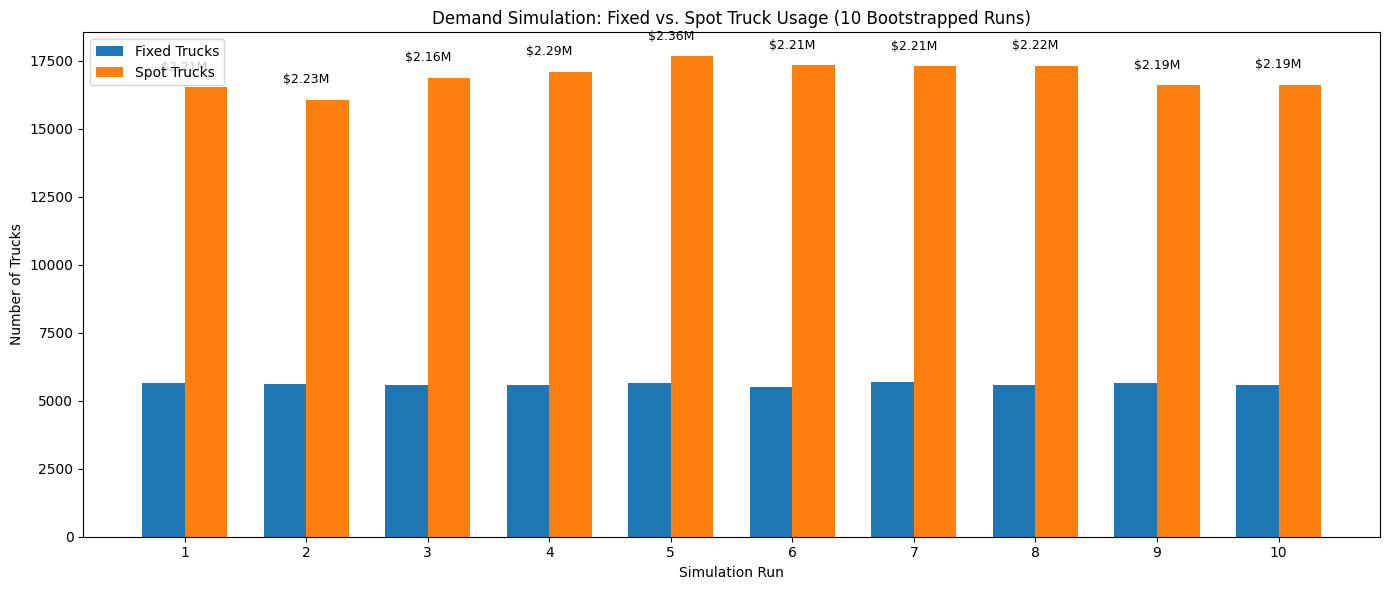

In [ ]:
import matplotlib.pyplot as plt

# Plot grouped bar chart using df_bootstrap
fig, ax1 = plt.subplots(figsize=(14, 6))

bar_width = 0.35
index = range(len(df_bootstrap))

# Plot fixed and spot trucks
ax1.bar([i - bar_width/2 for i in index], df_bootstrap["Fixed_Trucks"], bar_width, label="Fixed Trucks")
ax1.bar([i + bar_width/2 for i in index], df_bootstrap["Spot_Trucks"], bar_width, label="Spot Trucks")

# Add objective values as labels above bars
for i, val in enumerate(df_bootstrap["Objective"]):
    ax1.text(i, max(df_bootstrap["Fixed_Trucks"][i], df_bootstrap["Spot_Trucks"][i]) + 500,
             f"${val/1e6:.2f}M", ha='center', va='bottom', fontsize=9)

# Format axes and title
ax1.set_xlabel("Simulation Run")
ax1.set_ylabel("Number of Trucks")
ax1.set_title("Demand Simulation: Fixed vs. Spot Truck Usage (10 Bootstrapped Runs)")
ax1.set_xticks(index)
ax1.set_xticklabels(df_bootstrap["Run"])
ax1.legend()

plt.tight_layout()
plt.show()

## Baseline Analysis

In [ ]:
# Load cleaned customer demand (used in optimization)
df_cleaned = pd.read_csv("customer_demand.csv")

# Reload unfiltered baseline dataset
xl = pd.ExcelFile("Pivoted Dataset OG.xlsx")
df_raw = xl.parse("Turkey data New")

# Preprocess cleaned demand to extract matching keys
df_cleaned["Customer Promised Date"] = pd.to_datetime(df_cleaned["Customer Promised Date"])
df_cleaned["date_str"] = df_cleaned["Customer Promised Date"].dt.strftime("%Y-%m-%d")

# Create composite key for matching
cleaned_keys = set(zip(
    df_cleaned["destination_location_id"],
    df_cleaned["container_type"],
    df_cleaned["date_str"]
))

# Preprocess raw dataset to match structure
df_raw = df_raw.copy()
df_raw["Truck_Type"] = df_raw["Truck Type"].apply(lambda x: "Fixed" if "Leased" in str(x) else "3PL")
df_raw = df_raw[df_raw["Round Trip Distance"].notna()]
df_raw["Round Trip Distance"] = df_raw["Round Trip Distance"].astype(float)
df_raw["Customer Promised Date"] = pd.to_datetime(df_raw["Customer Promised Date"], errors="coerce")
df_raw["date_str"] = df_raw["Customer Promised Date"].dt.strftime("%Y-%m-%d")

# Create composite key in raw data
df_raw["key"] = list(zip(
    df_raw["destination_location_id"],
    df_raw["Equipment_type"],
    df_raw["date_str"]
))

# Filter raw dataset to only rows that match cleaned keys
df_filtered_baseline = df_raw[df_raw["key"].isin(cleaned_keys)].copy()
df_filtered_baseline.shape

(14469, 21)

In [ ]:
# Recalculate cost using filtered baseline
fixed_cost_per_km = 1.0
spot_multiplier = 1.15

df_filtered_baseline["Cost"] = df_filtered_baseline.apply(
    lambda row: row["Round Trip Distance"] * (
        fixed_cost_per_km if row["Truck_Type"] == "Fixed" else fixed_cost_per_km * spot_multiplier
    ),
    axis=1
)

# Group by truck type
baseline_summary = df_filtered_baseline.groupby("Truck_Type").agg(
    Trips=("Truck_Type", "count"),
    Total_Distance=("Round Trip Distance", "sum"),
    Total_Cost=("Cost", "sum")
).reset_index()

baseline_summary["%_Utilization"] = 100 * baseline_summary["Trips"] / baseline_summary["Trips"].sum()
baseline_summary = baseline_summary.sort_values("Truck_Type").reset_index(drop=True)

baseline_summary

,Truck_Type,Trips,Total_Distance,Total_Cost,%_Utilization
0,3PL,13208,3632642.0,4177538.3,91.284816
1,Fixed,1261,29625.0,29625.0,8.715184


In [ ]:
# Replace with your actual optimized values if different
optimized_fixed_trucks = 5784
optimized_spot_trucks = 17125
optimized_total_cost = 2257717.51

optimized_summary = pd.DataFrame({
    "Truck_Type": ["Fixed", "3PL"],
    "Trips": [optimized_fixed_trucks, optimized_spot_trucks]
})
optimized_summary["%_Utilization"] = 100 * optimized_summary["Trips"] / optimized_summary["Trips"].sum()

optimized_summary

,Truck_Type,Trips,%_Utilization
0,Fixed,5784,25.247719
1,3PL,17125,74.752281


In [ ]:
# Calculate cost savings
baseline_cost = baseline_summary["Total_Cost"].sum()
savings = baseline_cost - optimized_total_cost
percent_savings = (savings / baseline_cost) * 100

print(f"💰 Baseline Cost: ${baseline_cost:,.2f}")
print(f"✅ Optimized Cost: ${optimized_total_cost:,.2f}")
print(f"🎯 Cost Savings: ${savings:,.2f} ({percent_savings:.2f}%)")

💰 Baseline Cost: $4,207,163.30
✅ Optimized Cost: $2,257,717.51
🎯 Cost Savings: $1,949,445.79 (46.34%)


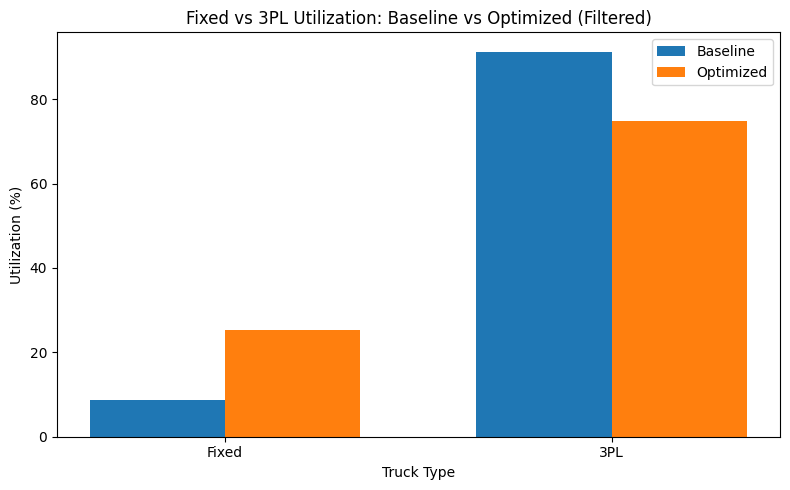

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Align truck types
baseline_util = baseline_summary.set_index("Truck_Type")["%_Utilization"]
optimized_util = optimized_summary.set_index("Truck_Type")["%_Utilization"]
truck_types = ["Fixed", "3PL"]

utilization_comparison = pd.DataFrame({
    "Truck_Type": truck_types,
    "Baseline (%)": [baseline_util.get(t, 0) for t in truck_types],
    "Optimized (%)": [optimized_util.get(t, 0) for t in truck_types]
})

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(utilization_comparison))

ax.bar(index - bar_width/2, utilization_comparison["Baseline (%)"], bar_width, label="Baseline")
ax.bar(index + bar_width/2, utilization_comparison["Optimized (%)"], bar_width, label="Optimized")

ax.set_xlabel("Truck Type")
ax.set_ylabel("Utilization (%)")
ax.set_title("Fixed vs 3PL Utilization: Baseline vs Optimized (Filtered)")
ax.set_xticks(index)
ax.set_xticklabels(utilization_comparison["Truck_Type"])
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Side-by-side summary table
summary_table = pd.DataFrame({
    "Metric": [
        "Fixed Truck Utilization (%)",
        "3PL Truck Utilization (%)",
        "Total Cost ($)"
    ],
    "Baseline": [
        baseline_util.get("Fixed", 0),
        baseline_util.get("3PL", 0),
        baseline_cost
    ],
    "Optimized": [
        optimized_util.get("Fixed", 0),
        optimized_util.get("3PL", 0),
        optimized_total_cost
    ]
})

# Format values
summary_table["Baseline"] = summary_table["Baseline"].apply(lambda x: f"{x:,.2f}" if isinstance(x, float) else x)
summary_table["Optimized"] = summary_table["Optimized"].apply(lambda x: f"{x:,.2f}" if isinstance(x, float) else x)

summary_table

,Metric,Baseline,Optimized
0,Fixed Truck Utilization (%),8.72,25.25
1,3PL Truck Utilization (%),91.28,74.75
2,Total Cost ($),"4,207,163.30","2,257,717.51"


## Sensitivity Analysis under Relaxed Assumptions

In [42]:
import pandas as pd
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB

def run_sensitivity_analysis(arcs_df, demand_df, shipments_df, max_fixed_list, max_distance_list, env_params):
    results = []

    # Initialize Gurobi environment
    env = gp.Env(params=env_params)

    # Preprocessing
    demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
    demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
    dates = sorted(demand_df["date_str"].unique())

    shipments_df["is_transit"] = shipments_df["Traffic Direction"] == "Transit"
    transit_keys = set(zip(
        shipments_df.loc[shipments_df["is_transit"], "source_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "destination_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "container_type"]
    ))

    demand = {}
    for _, row in demand_df.iterrows():
        key = (row["destination_location_id"], row["container_type"], row["date_str"])
        demand[key] = demand.get(key, 0) + row["q_i"]

    arcs = list(zip(arcs_df["source_location_id"], arcs_df["destination_location_id"]))
    distance = {
        (row["source_location_id"], row["destination_location_id"]): row["avg_distance"]
        for _, row in arcs_df.iterrows()
    }

    valid_keys = set()
    for (j, k, d) in demand:
        for (i, j2) in arcs:
            if j == j2:
                valid_keys.add((i, j, k, d))

    valid_keys_by_jkd = defaultdict(list)
    for (i, j, k, d) in valid_keys:
        valid_keys_by_jkd[(j, k, d)].append((i, j, k, d))

    for max_fixed_trucks in max_fixed_list:
        for max_daily_distance in max_distance_list:
            model = gp.Model(env=env)
            model.setParam("OutputFlag", 0)
            model.setParam("TimeLimit", 300)

            xf = model.addVars(valid_keys, vtype=GRB.INTEGER, name="xf")
            xs = model.addVars(valid_keys, vtype=GRB.INTEGER, name="xs")
            total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

            for (j, k, d) in demand:
                incoming = valid_keys_by_jkd.get((j, k, d), [])
                model.addConstr(gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming) >= demand[(j, k, d)])

            for (src, dst, cont) in transit_keys:
                for d in dates:
                    if (src, dst, cont, d) in valid_keys:
                        model.addConstr(xf[src, dst, cont, d] >= 1)

            for d in dates:
                model.addConstr(
                    gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
                    <= max_fixed_trucks
                )

            for d in dates:
                model.addConstr(
                    gp.quicksum(distance[i, j] * (xf[i, j, k, d1] + xs[i, j, k, d1])
                                for (i, j, k, d1) in valid_keys if d1 == d)
                    <= max_daily_distance * (max_fixed_trucks + total_spot)
                )

            model.addConstr(
                total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys)
            )

            model.setObjective(
                gp.quicksum(1.0 * distance[i, j] * xf[i, j, k, d] +
                            1.15 * distance[i, j] * xs[i, j, k, d]
                            for (i, j, k, d) in valid_keys) + 50 * total_spot,
                GRB.MINIMIZE
            )

            model.optimize()

            if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
                results.append({
                    "max_fixed_trucks": max_fixed_trucks,
                    "max_daily_distance": max_daily_distance,
                    "objective_cost": model.ObjVal,
                    "spot_trucks_used": total_spot.X,
                    "fixed_truck_moves": sum(xf[i, j, k, d].X for (i, j, k, d) in valid_keys)
                })

    return pd.DataFrame(results)

In [43]:
results_df = run_sensitivity_analysis(
    arcs_df=arcs_df,
    demand_df=demand_df,
    shipments_df=shipments_df,
    max_fixed_list=[18, 22, 26],
    max_distance_list=[400, 500, 600],
    env_params={
        "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
        "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
        "LICENSEID": 2615231
    }
)

results_df

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu


,max_fixed_trucks,max_daily_distance,objective_cost,spot_trucks_used,fixed_truck_moves
0,18,400,2.257718e+06,17125.0,5784.0
1,18,500,2.257718e+06,17125.0,5784.0
2,18,600,2.257718e+06,17125.0,5784.0
3,22,400,2.188994e+06,15947.0,6962.0
4,22,500,2.188994e+06,15947.0,6962.0
5,22,600,2.188994e+06,15947.0,6962.0
6,26,400,2.123926e+06,14801.0,8108.0
7,26,500,2.123926e+06,14801.0,8108.0
8,26,600,2.123926e+06,14801.0,8108.0


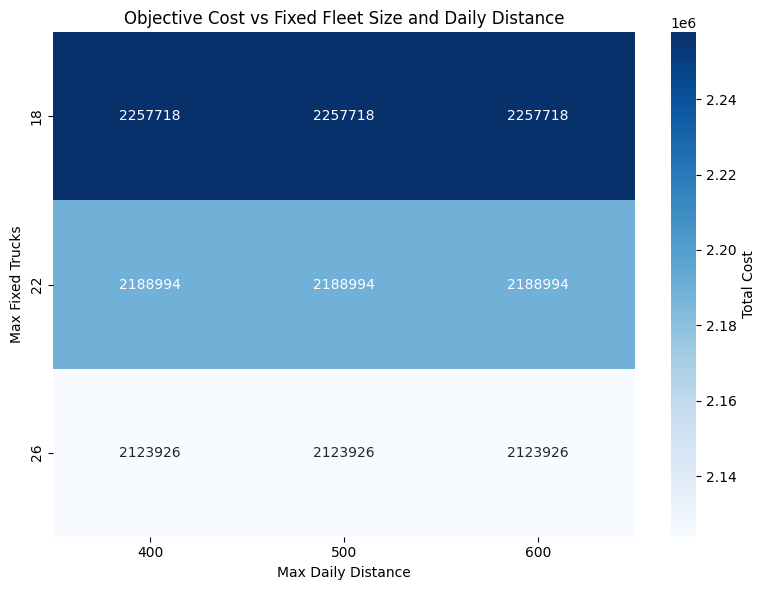

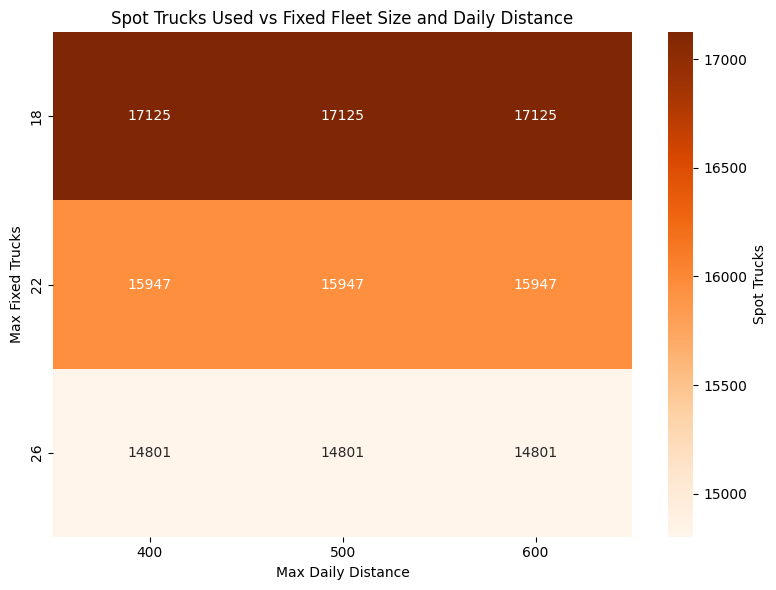

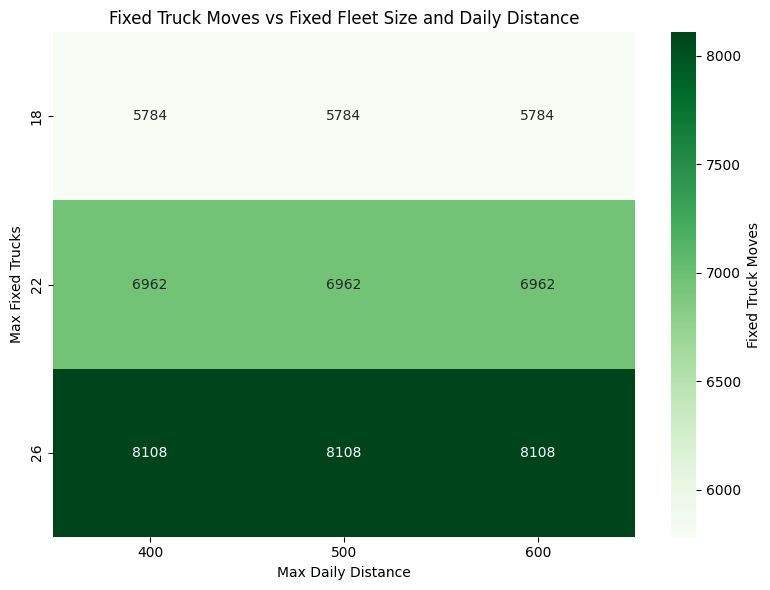

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap 1: Objective Cost
plt.figure(figsize=(8, 6))
pivot_obj = results_df.pivot(index="max_fixed_trucks", columns="max_daily_distance", values="objective_cost")
sns.heatmap(pivot_obj, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Total Cost'})
plt.title("Objective Cost vs Fixed Fleet Size and Daily Distance")
plt.xlabel("Max Daily Distance")
plt.ylabel("Max Fixed Trucks")
plt.tight_layout()
plt.show()

# Heatmap 2: Spot Trucks Used
plt.figure(figsize=(8, 6))
pivot_spot = results_df.pivot(index="max_fixed_trucks", columns="max_daily_distance", values="spot_trucks_used")
sns.heatmap(pivot_spot, annot=True, fmt=".0f", cmap="Oranges", cbar_kws={'label': 'Spot Trucks'})
plt.title("Spot Trucks Used vs Fixed Fleet Size and Daily Distance")
plt.xlabel("Max Daily Distance")
plt.ylabel("Max Fixed Trucks")
plt.tight_layout()
plt.show()

# Heatmap 3: Fixed Truck Moves
plt.figure(figsize=(8, 6))
pivot_fixed = results_df.pivot(index="max_fixed_trucks", columns="max_daily_distance", values="fixed_truck_moves")
sns.heatmap(pivot_fixed, annot=True, fmt=".0f", cmap="Greens", cbar_kws={'label': 'Fixed Truck Moves'})
plt.title("Fixed Truck Moves vs Fixed Fleet Size and Daily Distance")
plt.xlabel("Max Daily Distance")
plt.ylabel("Max Fixed Trucks")
plt.tight_layout()
plt.show()

## Bootstrapping Analysis

In [45]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import seaborn as sns

# Define your basic optimization function
def run_single_optimization(arcs_df, demand_df, shipments_df, max_fixed_trucks, max_daily_distance, env_params):
    env = gp.Env(params=env_params)
    model = gp.Model(env=env)
    model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 180)

    # Preprocessing
    demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
    demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
    dates = sorted(demand_df["date_str"].unique())

    shipments_df["is_transit"] = shipments_df["Traffic Direction"] == "Transit"
    transit_keys = set(zip(
        shipments_df.loc[shipments_df["is_transit"], "source_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "destination_location_id"],
        shipments_df.loc[shipments_df["is_transit"], "container_type"]
    ))

    arcs = list(zip(arcs_df["source_location_id"], arcs_df["destination_location_id"]))
    distance = {(row["source_location_id"], row["destination_location_id"]): row["avg_distance"] for _, row in arcs_df.iterrows()}

    # Demand dictionary
    demand = {}
    for _, row in demand_df.iterrows():
        key = (row["destination_location_id"], row["container_type"], row["date_str"])
        demand[key] = demand.get(key, 0) + row["q_i"]

    valid_keys = set()
    for (j, k, d) in demand:
        for (i, j2) in arcs:
            if j == j2:
                valid_keys.add((i, j, k, d))

    from collections import defaultdict
    valid_keys_by_jkd = defaultdict(list)
    for (i, j, k, d) in valid_keys:
        valid_keys_by_jkd[(j, k, d)].append((i, j, k, d))

    # Variables
    xf = model.addVars(valid_keys, vtype=GRB.INTEGER, name="xf")
    xs = model.addVars(valid_keys, vtype=GRB.INTEGER, name="xs")
    total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

    # Constraints
    for (j, k, d) in demand:
        incoming = valid_keys_by_jkd.get((j, k, d), [])
        model.addConstr(gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming) >= demand[(j, k, d)])

    for (src, dst, cont) in transit_keys:
        for d in dates:
            if (src, dst, cont, d) in valid_keys:
                model.addConstr(xf[src, dst, cont, d] >= 1)

    for d in dates:
        model.addConstr(
            gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
            <= max_fixed_trucks
        )

    for d in dates:
        model.addConstr(
            gp.quicksum(distance[i, j] * (xf[i, j, k, d1] + xs[i, j, k, d1])
                        for (i, j, k, d1) in valid_keys if d1 == d)
            <= max_daily_distance * (max_fixed_trucks + total_spot)
        )

    model.addConstr(
        total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys)
    )

    # Objective
    model.setObjective(
        gp.quicksum(1.0 * distance[i, j] * xf[i, j, k, d] +
                    1.15 * distance[i, j] * xs[i, j, k, d]
                    for (i, j, k, d) in valid_keys) + 50 * total_spot,
        GRB.MINIMIZE
    )

    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        return {
            "objective_cost": model.ObjVal,
            "spot_trucks_used": total_spot.X,
            "fixed_truck_moves": sum(xf[i, j, k, d].X for (i, j, k, d) in valid_keys)
        }
    else:
        return None

In [48]:
# Bootstrap setup
num_bootstrap_samples = 5  # you can increase to 100+ if time allows
bootstrap_results = []

# Parameters
fixed_trucks = 22  # pick the relaxed assumption you want to study
daily_distance = 500
env_params = {
    "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
    "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
    "LICENSEID": 2615231
}

for i in range(num_bootstrap_samples):
    # Resample demand with replacement
    resampled_demand = demand_df.sample(frac=1.0, replace=True, random_state=i)

    # Run optimization on resampled dataset
    result = run_single_optimization(arcs_df, resampled_demand, shipments_df,
                                     max_fixed_trucks=fixed_trucks,
                                     max_daily_distance=daily_distance,
                                     env_params=env_params)
    if result:
        bootstrap_results.append(result)

# Turn into DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu


       objective_cost  spot_trucks_used  fixed_truck_moves
count    5.000000e+00           5.00000           5.000000
mean     2.198865e+06       16083.60000        6713.000000
std      7.366792e+04         350.19823          52.426139
min      2.143364e+06       15620.00000        6661.000000
25%      2.163345e+06       15936.00000        6663.000000
50%      2.177841e+06       16002.00000        6708.000000
75%      2.181927e+06       16370.00000        6762.000000
max      2.327849e+06       16490.00000        6771.000000


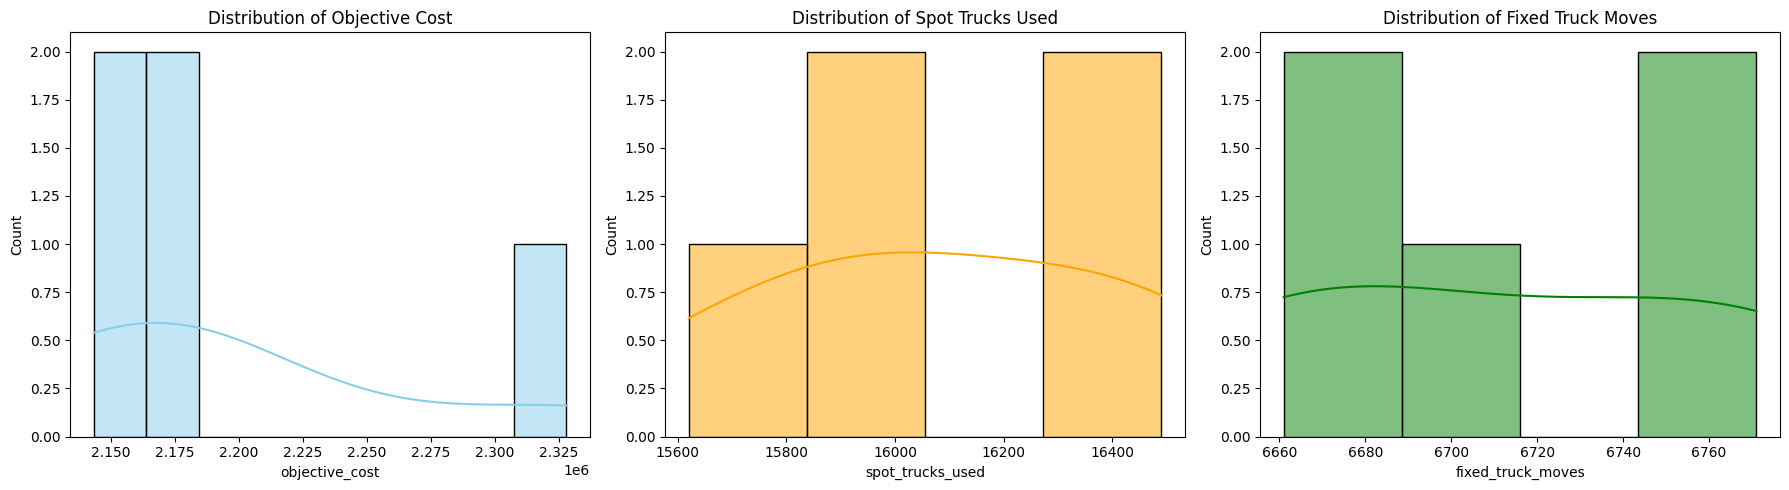

In [49]:
# Summarize
print(bootstrap_df.describe())

# Plot distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(bootstrap_df["objective_cost"], kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Distribution of Objective Cost")

sns.histplot(bootstrap_df["spot_trucks_used"], kde=True, ax=axs[1], color="orange")
axs[1].set_title("Distribution of Spot Trucks Used")

sns.histplot(bootstrap_df["fixed_truck_moves"], kde=True, ax=axs[2], color="green")
axs[2].set_title("Distribution of Fixed Truck Moves")

plt.tight_layout()
plt.show()